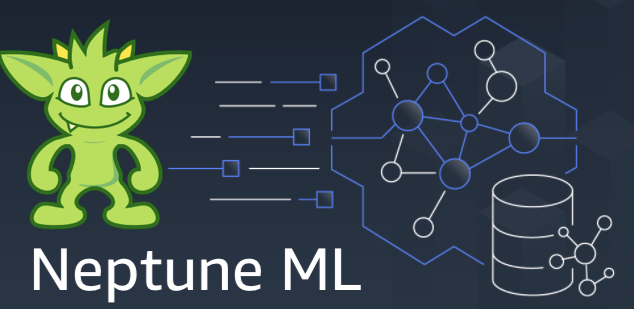

# Text Encoder Tutorial - Introduction 

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This notebook take approximately 1 hour to complete</div>

[Neptune ML](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview) is a feature of Amazon Neptune that enables users to automate the creation, management, and usage of machine learning on graph structured data within Amazon Neptune. Neptune ML is built using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [Deep Graph Library](https://www.dgl.ai/) to provide a simple mechanism for training and deploying these models.  Since Neptune ML is integrated deeply with Amazon Neptune, predictions can be made directly through the Gremlin query language. 

The graphs stored in Neptune have diverse node and edge properties. Typically, the properties are in numerical type, like the `age` or `the count of job history` for a `user` node. However, in practice, the node or edge properties are more common in the form of raw text, like the `self description` property of a `user` node and the `description` or the `requirement` of a `job` node. Moreover, the text properties in a graph can be in different languages, thinking of the job posts in different countries which may be described in different languages. Also, the length of the text properties varies. Some are long and some are short. Due to these requirements, customers need an efficient and effective way to encode text data in a graph feature processing step.

This tutorial will illustrate the usage of different text encoders in Neptune ML and compare their pros and cons. The goal of text encoding is to convert the text features in Neptune into meaningful fixed-size vectors that can then be used to solve downstream tasks.  There are at least two complications:
- The length of the text feature can vary a lot. It can be a word, a phrase, a sentence, a paragraph, or even a document with multiple paragraphs (the maximum size of a single property is 55MB in Neptune). 
- The text can be from different languages, such as English, Spanish, Chinese, etc. There may also be sentences that contain words in several different languages, which we define as `code-switching`. 

With version 1.1.0.0, Neptune ML supports multiple text encoding models that are optimized for different scenarios:

- [text_fasttext](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-feature-encoding.html#machine-learning-fasttext-features)  – Uses [fastText](https://fasttext.cc/) encoding. FastText is a library for efficient text representation learning. `text_fasttext` is the recommended choice for text that is one and only one of the following five languages that fastText supports:  English, Chinese, Hindi, Spanish, and French. The text_fasttext method can optionally take `max_length` field that specifies the maximum number of tokens in a text property value that will be encoded, after which the string is truncated. This can improve performance when text property values contain long strings, because if `max_length` is not specified, fastText encodes all the tokens regardless of the string length. New in version 1.1.0.0.
- [text_sbert](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-feature-encoding.html#machine-learning-sbert-features)  – Uses the [Sentence BERT](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models) (SBERT) encoding method. SBERT is a kind of sentence embedding method using the contextual representation learning models, BERT-Networks. `text_sbert` is the recommended choice for languages that `text_fasttext` does not support. Neptune supports two SBERT methods: `text_sbert128`, which is the default if you just specify `text_sbert`, and `text_sbert512`. The difference between them is the maximum number of tokens in a text property that gets encoded. The `text_sbert128` encoding only encodes the first 128 tokens, while `text_sbert512` encodes up to 512 tokens. As a result, using `text_sbert512` can require more processing time than `text_sbert128`. Both methods are slower than `text_fasttext`. New in version 1.1.0.0.
- [text_word2vec](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-feature-encoding.html#machine-learning-word2vec-features)  – Uses [Word2Vec](https://wikipedia.org/wiki/Word2vec) algorithms originally published by [Google](https://code.google.com/archive/p/word2vec/) to encode text. Word2Vec only supports English. This is the first text encoder released in NeptuneML. After version 1.1.0.0, we have more encoder options like `text_fasttext` and `text_sbert` for the Engligh text properties.
- [text_tfidf](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-feature-encoding.html#machine-learning-tfidf-features)  – Uses a [term frequency–inverse document frequency](https://wikipedia.org/wiki/Tf-idf) (TF-IDF) vectorizer for encoding text. TF-IDF supports statistical features that the other encodings do not. It quantifies the importance or relevance of words in one node property among all the other nodes.

Users can specify these choices directly or rely on Neptune ML's `auto` option to automatically recommend an encoding method based on the characteristics of the data.  

## Comparison of Different Text Encoders <a id='#comparison'></a>

A detailed comparison of the all the model-based methods is shown below. 

  Property\Encoder |`text_fasttext` |`text_sbert` | `text_word2vec`
 :-----: | :-----: | :-----: | :-----: 
Supported Language |Supports 5 languages: English, Chinese, Hindi, Spanish, and French |Supports [more than 50 languages](https://www.sbert.net/docs/pretrained_models.html#multi-lingual-models) | Supports English
Can encode sentences that contain words in several different languages or not| No | Yes | No 
Max-length Support|No maximum length limit|Encode the text sequence with the maximum length of 128 and 512 | No maximum length limit
Loading Time |~10s for each language model| ~2s | ~2s for English model
Inference Speed | Fast for long text sequences | Slow in CPU inference | Slower than `fasttext` but faster than `sbert`

Note that `text_tfidf` is not a *model-based* encoding method that attempts to capture the meaning of words, but rather a count-based method that only considers how common or rare words are.  

## Usage Demo

In this tutorial, we are going to show how to utilize different text encoders in a link prediction task. Link prediction is an unsupervised machine learning task where a model is built to predict whether an edge exists between two particular nodes.  Here, we use a Graph Neural Network (GNN) model, which can leverage both the graph structure (i.e., how the edges connect the varoius nodes) and the properties of the nodes/edges.  

### Dataset and Task Description
We'll use the [job recommendation dataset](https://www.kaggle.com/competitions/job-recommendation/data) provided by [Kaggle](https://www.kaggle.com/) to walk through how Neptune ML can make job recommendations. We extracted a subset of dataset with the criteria that (1) each user should have applied at least five jobs and at most ten jobs, and (2) each job must have been applied by at least three users. A preprocess data variant is in `s3://neptuneml-data/kaggle-job-recommend/`.

The following figure shows the dataset summary and entity relations. The main relation is the **apply** relation between a **user** and a **job**.

<div>
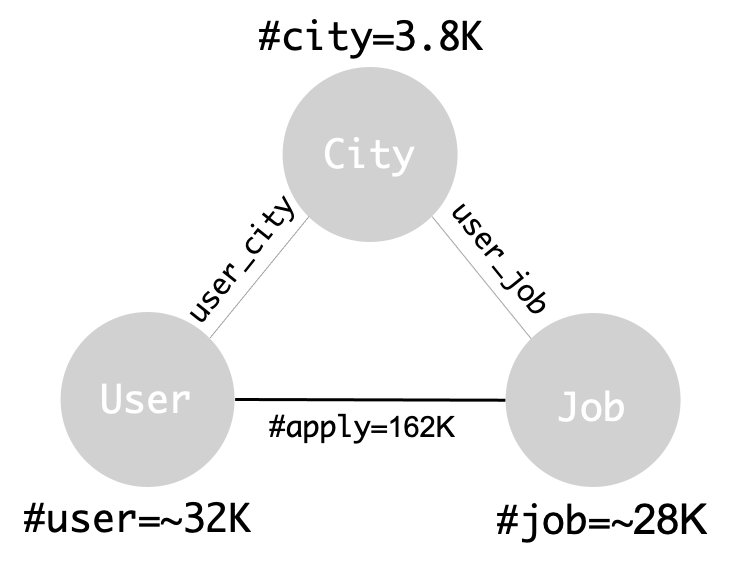
</div>

This dataset consists of user profiles, job details, and locations.

Users have the following properties: 
- **State**, e.g., `CA`,  `广东省` (Chinese), etc
- **Major**: e.g., `Human Resources Management`, `Lic Cytura Fisica` (Spanish), etc
- **DegreeType**, e.g., `Bachelor's`, `Master's`, `PhD`, `None`, etc
- **WorkHistoryCount**: e.g., `0`, `1`, `16`, etc
- **TotalYearsExperience**: e.g., `0.0`, `10.0`, NAN, etc
- **ManagedOthers**: i.e., `Yes` or `No`
- **ManagedHowMany**: e.g., `0`, `10`, etc

Jobs have the following properties:
- **Title**: e.g., `Administrative Assistant`, `Lic Cultura Física` (Spanish), etc.
- **Description**: e.g., `This Administrative Assistant position is responsible for performing a variety of clerical and administrative support functions in the areas of communications, ...`, etc
    - The average words of description is around 192.2.
- **Requirements**: e.g., `JOB REQUIREMENTS: 1. Attention to detail; 2.Ability to work in a fast paced environment;3.Invoicing...`
- **State**: e.g., `CA`, `NY`, etc

The node type **city** only has the identifier for each node. 




In the following, we will show how to choose different text encoders for different text properties and predict the jobs that a user would be most likely to apply.
We'll walk through each step of loading and exporting the data, configuring and training the model, and finally we'll show how to use that model to infer the recommended jobs using Gremlin traversals. 

### Step1: Load Data: Prepare System Environment and Dataset
First, to check that this cluster is configured to run Neptune ML. Then, (optional) clear existing datasets in the Neptune cluster. And finally, load the Neptune-formartted job recommendatation dataset from `s3://neptuneml-data/kaggle-job-recommend`.

In [ ]:
import neptune_ml_utils as neptune_ml
neptune_ml.check_ml_enabled()

In [ ]:
%load -f csv -p OVERSUBSCRIBE --run -s s3://neptuneml-data/kaggle-job-recommend

#### Dataset Analysis
Once the cell has completed, the data has been loaded into the cluster. We verify the data loaded correctly by running the traversals below to see the count of nodes by label:  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The numbers below assume no other data is in the cluster</div>

In [ ]:
%%gremlin
g.V().groupCount().by(label).unfold()

If our nodes loaded correctly then the output is:

* 32,594 users
* 27,707 jobs
* 3,799 cities


To check that our edges loaded correctly we check the edge counts:

In [ ]:
%%gremlin
g.E().groupCount().by(label).unfold()

If our edges loaded correctly then the output is:

* 162,125 apply
* 27,707 job_city
* 32,594 user_city

#### Data Sample Analysis 
For a specific user, we can use Gremlin to check the Major of the user and what jobs the user has applied to. Here, we take the node `user_443931` as an example.

In [ ]:
%%gremlin
g.V('user_443931').valueMap('Major')

In [ ]:
%%gremlin
g.V('user_443931').out('apply').hasLabel('job').valueMap('Title')

#### Drop the apply edges for further prediction

With our data validated, let's remove a few **apply** links so that we can build a model that predicts these missing connections. Specifically, let's remove two **apply** edges for `user_443931` to provide us with a few candidate vertices to run our link prediction tasks. 

First, we check all the edge ids connected with `user_443931`.

In [ ]:
%%gremlin
g.V('user_443931').outE('apply')

From the results, we find that there are five **apply** edges and we plan to delete two connected edges, `app_84898` and `app_5325`. 

In [ ]:
%%gremlin
g.V('job_587120').valueMap('Title')

In [ ]:
%%gremlin
g.E('app_84898').drop()

In [ ]:
%%gremlin
g.V('job_26829').valueMap('Title')

In [ ]:
%%gremlin
g.E('app_5325').drop()

Checking our data again, we see that two of five edges have now been removed. Only three edges are left.

In [ ]:
%%gremlin
g.V('user_443931').out('apply').hasLabel('job').valueMap('Title')

### Step 2: Export Data: Choose the Right Text Encoders for Text Properties

**Note:** Before exporting data ensure that Neptune Export has been configured as described here: [Neptune Export Service](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export.html). 

The export process is triggered by calling to the [Neptune Export service endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export.html).  This call contains a configuration object, which specifies the link prediction task on the edge of `("user", "apply", "job")` for this job recommendation problem.  The configuration also specifies the desired feature processing to apply.

#### Configuring features
In machine learning, each property is transformed into a "feature", and these features are used by the model to make predictions.  When data is exported from Neptune, all properties of all vertices are included.  Each property is treated as a separate feature for the ML model.  Neptune ML does its best to infer the correct type of feature for a property. In many cases, the accuracy of the model can be improved by specifying information about the property used for a feature. 

In this tutorial, we only specify the text features and show how to select different text encoders for different text properties.

The **user** nodes have one kind of text property: 
- **Major**: e.g., `Human Resources Management`, `Lic Cytura Fisica` (Spanish), etc.

The **job** nodes have three kinds of text properties:
- **Title**: e.g., `Administrative Assistant`, `Lic Cultura Física` (Spanish), etc.
- **Description**: e.g., `This Administrative Assistant position is responsible for performing a variety of clerical and administrative support functions in the areas of communications, ...`, etc
    - The average words of description is around 192.2.
- **Requirements**: e.g., `JOB REQUIREMENTS: 1. Attention to detail; 2.Ability to work in a fast paced environment;3.Invoicing...`

*Tips*: The **Major** and **Title** properties are in multiple languages and have short text sequences, so `text_sbert` is recommended. The **Description** and **Requirements** properties are usually in long text sequences. The average words of description is around 192, which is longer than the maximum input length of `text_sbert`(i.e., 128). We can use `text_sbert512`, but it may result in slow inference and the text are in single language i.e., English. So we recommend to choose `text_fasttext` with the `en` language because of its fast inference and not limited input length.

Other property types like **State**, **DegreeType**, **ManagedOthers** are represented as `category` features. In this feature type, each unique value of data is represented as a unique value. Properties like **WorkHistoryCount**, **TotalYearsExperience**, and **ManagedHowMany** can be treated as a `numerical` feature type. In this feature type data is represented as a continuous set of numbers.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Important</b>: The example below is an example of a minimal amount of the features of the model configuration parameters and will not create the most accurate model possible.  Additional options are available for tuning this configuration to produce an optimal model are described here: <a href="https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-parameters.html">Neptune Export Process Parameters</a></div>

In [ ]:
s3_bucket_uri="s3://<INSERT S3 BUCKET OR PATH>"
s3_bucket_uri = s3_bucket_uri[:-1] if s3_bucket_uri.endswith('/') else s3_bucket_uri

In [ ]:
export_params={ 
"command": "export-pg", 
"params": { "endpoint": neptune_ml.get_host(),
            "profile": "neptune_ml",
            "cloneCluster": False
            }, 
"outputS3Path": f'{s3_bucket_uri}/neptune-export',
"additionalParams": {
        "neptune_ml": {
        "version": "v2.0",
        "targets": [
            {
            "edge": ["user", "apply", "job"],
            "type" : "link_prediction",
            "split_rate": [0.8,0.1,0.1]
            }
        ],
         "features": [
            {
                "node": "user",
                "property": "Major",
                "type": "text_sbert"
            },
            {
                "node": "job",
                "property": "Title",
                "type": "text_sbert",
            },
            {
                "node": "job",
                "property": "Description",
                "type": "text_fasttext",
                "language": "en"
            },
            {
                "node": "job",
                "property": "Requirements",
                "type": "text_fasttext",
                "language": "en"
            }
         ]
        }
      },
"jobSize": "medium"}

In [ ]:
%%neptune_ml export start --export-url {neptune_ml.get_export_service_host()} --export-iam --wait --store-to export_results
${export_params}

### Step 3: ML data processing, model training, and endpoint creation

Once the export job is completed we are now ready to train our machine learning model and create the inference endpoint. Training our Neptune ML model requires three steps: data processing, model training, and endpoint creation.

#### Data Processing

Data processing is implemented using a SageMaker Processing Job and data artifacts are stored in a pre-specified S3 location once the job is complete. Additional options and configuration parameters for the data processing job can be found using the links: [data processing](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-processing.html) and [dataprocessing command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-dataprocessing.html).
Run the cells below to create the data processing configuration and to begin the processing job.

In [ ]:
# The training_job_name can be set to a unique value below, otherwise one will be auto generated
training_job_name=neptune_ml.get_training_job_name('link-prediction')

processing_params = f"""
--config-file-name training-data-configuration.json
--job-id {training_job_name} 
--s3-input-uri {export_results['outputS3Uri']} 
--s3-processed-uri {str(s3_bucket_uri)}/preloading """
print(processing_params)

In [ ]:
%neptune_ml dataprocessing start --wait --store-to processing_results {processing_params}

In [ ]:
print(processing_results)

#### Model training
The model training is done in two stages. The first stage uses a SageMaker Processing job to generate a model training strategy, which is a configuration that specifies the type of model and the ranges to search for each of the training hyperparameters. This SageMaker Processing job uses the configuration to then launch a SageMaker Hyperparameter Optimization (HPO) job that will attempt to find the parameter values that maximize model performance. To do this, the SageMaker HPO job runs a pre-specified number of model training job trials to intelligently search the hyperparameter ranges for the optimal value.  The model artifacts of each training job are stored in the output S3 location and once all the training jobs are complete, the best performing model is chosen.

Additional options and configuration parameters for training models can be found using the links below: [Model Training](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-model-training.html) and [modeltraining command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-modeltraining.html).

In [ ]:
training_params=f"""
--job-id {training_job_name} 
--data-processing-id {training_job_name} 
--instance-type ml.g4dn.4xlarge
--s3-output-uri {str(s3_bucket_uri)}/training
--max-hpo-number 10
--max-hpo-parallel 2 """
print(training_params)

In [ ]:
%neptune_ml training start --wait --store-to training_results {training_params}

#### Endpoint creation
The final step is to create a SageMaker endpoint with the model artifacts produced by the best training job to serve model predictions. This endpoint is integrated with the Neptune database and can be invoked by issuing Gremlin graph queries.

Additional options and configuration parameters for deploying Neptune ML endpoints can be found using the links below: [Inference Endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-inference-endpoint.html) and [Endpoint command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-endpoints.html).

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Information</b>: The endpoint creation process takes ~5-10 minutes</div>

In [ ]:
endpoint_params=f"""
--id {training_job_name}
--model-training-job-id {training_job_name}
--instance-type ml.m5d.xlarge
"""
print(endpoint_params)

In [ ]:
%neptune_ml endpoint create --wait --store-to endpoint_results {endpoint_params}

Once this has completed we get the endpoint name for our newly created inference endpoint.  The cell below will set the endpoint name which will be used in the Gremlin queries below.   

In [ ]:
endpoint=endpoint_results['endpoint']['name']
print(endpoint)

### Step 4: Querying using Gremlin

Now that we have our inference endpoint setup, let's use the well-trained model to check the jobs that the model recommends for the user.

Link prediction can infer any of the edge labels that existed in our graph when the model was created. In our model, this means we could infer the probability that a edge `apply` exists between any two vertices `user` and `job`. 

#### Predicting what job a user will apply
Before we predict what jobs `user_443931` is most likely to apply for, let's verify that our graph only contains three  `apply` edges for `user_443931`.

In [ ]:
%%gremlin
g.V('user_443931').valueMap('Major')

In [ ]:
%%gremlin
g.V('user_443931').out('apply').hasLabel('job').valueMap('Title')

As expected, now `user_443931` has applied three jobs. And we want to provide some job recommendations based on the history job applications. Let's modify the query to predict what jobs `user_443931` is most likely to apply for.

First, we add the `with()` step to specify the inference endpoint we want to use with our Gremlin query like this
`g.with("Neptune#ml.endpoint","<INSERT ENDPOINT NAME>")`.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The endpoint values are automatically passed into the queries below</div>

Second, when we ask for the link within our query we use the `out()` step to predict the target node, or alternatively the `in()` step to predict the source node.  For each of these steps we need to specify the type of model being used with a `with()` clause: `with("Neptune#ml.prediction")`.

Putting these items together we get the query below, which returns 10 job titles that` user_443931` is likely to apply for.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").with("Neptune#ml.limit",10).
    V('user_443931').out('apply').with("Neptune#ml.prediction").hasLabel('job').valueMap('Title')

Great! Now we can see the top 10 jobs that `user_443931` is most likely to apply for. The deleted two jobs, `Human Resources Administrator` and `Human Resources (HR) Manager` are in the top10 predictions.

### Step 5: Cleaning Up 
Now that you have completed this walkthrough you have created a Sagemaker endpoint which is currently running and will incur the standard charges.  If you are done trying out Neptune ML and would like to avoid these recurring costs, run the cell below to delete the inference endpoint.

In [ ]:
neptune_ml.delete_endpoint(training_job_name)

In addition to the inference endpoint, the CloudFormation script that you used has setup several additional resources.  If you are finished then we suggest you delete the CloudFormation stack to avoid any recurring charges. For instructions, see Deleting a Stack on the [Deleting a Stack on the Amazon Web Services CloudFormation Console](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/cfn-console-delete-stack.html). Be sure to delete the root stack (the stack you created earlier). Deleting the root stack deletes any nested stacks.

## Conclusions
Overall, the text encoders are easy to use and can support multiple requirements. In general, `text_fasttext` is the recommended encoding for features that use one and only one of the five languages that fastText supports. `text_sbert` is the recommended encoding for text that `text_fasttext` does not support. `text_word2vec` only supports English and can be replaced by `text_fasttext` in any scenario.